# HW5: Named-Entity Recognition

이번 과제에서는 GRU(gated recurrent unit)를 이용해 NER(named-entity recognition) 작업을 해보도록 하겠다. NER은 문장에서 명명된 개체를 찾아서 사람 이름, 조직, 위치, 의료 코드, 시간 표현, 수량, 화폐 가치, 백분율 등과 같이 미리 정의된 카테고리로 분류하는 정보 추출 작업이다.

<br/>
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*oyOE7LB7-KKRETBpsHRJPg.png" />
<br/>

**이번 과제에서는 GPU를 이용한다. 이를 위해서는 메뉴의 [런타임]-[런타임 유형 변경]에서 '하드웨어 가속기'를 'T4 GPU'로 선택해야 한다.**

우선 필요한 모듈을 불러오고, 필요한 셋팅을 한다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt # Matplotlib
import pandas as pd
import torch
import torch.nn as nn

## 데이터셋 로딩

이번 과제에서는 [Kaggle](https://www.kaggle.com/)에서 제공하는 [NER 데이터셋](https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus)을 사용한다.

우선 데이터셋을 다운로드 받고 압축을 푼다.

In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hBpe9j9wbOw4HhCKcbP_D0mog0_-IR9Q' -O ner_dataset.csv

--2025-11-07 14:00:33--  https://docs.google.com/uc?export=download&id=1hBpe9j9wbOw4HhCKcbP_D0mog0_-IR9Q
Resolving docs.google.com (docs.google.com)... 74.125.20.113, 74.125.20.101, 74.125.20.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1hBpe9j9wbOw4HhCKcbP_D0mog0_-IR9Q&export=download [following]
--2025-11-07 14:00:33--  https://drive.usercontent.google.com/download?id=1hBpe9j9wbOw4HhCKcbP_D0mog0_-IR9Q&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.98.132, 2607:f8b0:400e:c02::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.98.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15208151 (15M) [application/octet-stream]
Saving to: ‘ner_dataset.csv’

ner_dataset.csv     100%[===================>]  14.50M  54.4MB/s    in 0

데이터셋은 **ner_dataset.csv** 파일로 저장되며, CSV(comma-seperated values) 형식을 갖는다. 이는 엑셀을 통해서도 열어볼 수 있다. 이번 과제에서는 CSV 파일을 쉽게 처리할 수 있도록, 데이터 분석에 널리 사용하는 [Pandas](https://pandas.pydata.org/) 라이브러리를 사용한다. Pandas는 2차원 테이블 형태의 데이터를 [Data Frame 구조](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)로 관리한다.

우선 **ner_dataset.csv** 파일을 불러온다.

In [3]:
data = pd.read_csv('ner_dataset.csv', encoding='unicode_escape') # CSV 파일을 불러온다.
data.head(10) # 일부 데이터를 출력한다.

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


데이터는 4개의 열로 구성되어 있다. **Sentence #** 열은 문장 번호를 나타낸다. 이 때, **Sentence: #** 값은 다음과 같은 패턴을 가지고 있다. **Sentence: 1**이 나타나고 나서 **NaN** 값이 계속 나오다가, 다시 **Sentence: 2**가 나타난다. 그리고 다시 **NaN** 값이 나온다. 이는 하나의 문장을 [토큰(token)](https://ko.wikipedia.org/wiki/%EB%82%B1%EB%A7%90_%EB%B6%84%EC%84%9D)으로 나눠놓은 것으로, 'Sentence: 숫자'부터 다음 'Sentence: 숫자'가 나오기 전까지가 하나의 문장을 구성한다.

**Word** 열은 문장을 구성하는 토큰(token)을 나타낸다. **POS** 열은 본 과제에서는 필요가 없다. **Tag** 열은 토큰을 분류한 정보로 그 의미는 다음과 같다:

|Tag|의미|
|------|---|
|O|분류 안됨|
|geo|Geographical Entity|
|org|Organization|
|per|Person|
|gpe|Geopolitical Entity|
|tim|Time indicator|
|art|Artifact|
|eve|Event|
|nat|Natural Phenomenon|

**Tag** 앞에 붙은 **I**와 **B**는 무시한다.

**Sentence: 1**의 문장을 보면 다음과 같이 해석할 수 있다:

|Thousands|of|demonstrators|have|marched|through|London|...|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|O|O|O|O|O|O|geo|...|

## 단어 인덱싱(Word Indexing)

Neural network은 문자로 표현된 단어를 직접 입력 데이터로 사용할 수 없기 때문에, 단어를 수치로 변환해야 한다. 따라서, NER 데이터셋의 **Word** 열과 **Tag** 열의 단어들을 수치로 변환한다.

우선, 데이터셋에 있는 단어들을 중복되지 않게 추출한다.

In [4]:
vocab_tokens = list(set(data['Word'].to_list())) # 중복되는 토큰(Word 열)을 제거한다.
vocab_tags = list(set(data['Tag'].to_list())) # 중복되는 태그(Tag 열)를 제거한다.

print("중복되지 않는 토큰 갯수:", len(vocab_tokens)) # 35178
print("중복되지 않는 태그 갯수:", len(vocab_tags)) # 17

중복되지 않는 토큰 갯수: 35178
중복되지 않는 태그 갯수: 17


단어들에 순서대로 번호를 매겨 단어 사전을 만든다. 이 때, 나중에 사용할 **PAD**라는 특수한 토큰을 먼저 추가한다.

작업 후, *token2index*에는 각 토큰에 대한 인덱스 변환 정보가 저장되고, *tag2index*에는 태그에 대한 인덱스 변환 정보가 저장된다.

In [5]:
def create_index(vocabs):
  vocab2index = {}
  vocab2index['<PAD>'] = 0
  for index, vocab in enumerate(vocabs):
    vocab2index[vocab] = index+1

  return vocab2index

token2index = create_index(vocab_tokens) # 토큰 to 인덱스 사전
tag2index = create_index(vocab_tags) # 태그 to 인덱스 사전

사전의 단어 갯수를 확인한다.

In [6]:
print("토큰 갯수:", len(token2index)) # 35179
print("태그 갯수:", len(tag2index)) # 18

토큰 갯수: 35179
태그 갯수: 18


다음 코드는 *token2index*와 *tag2index*의 일부 내용을 출력한다.

In [7]:
print("Word to index")
print([pair for pair in list(token2index.items())[:5]])

print("Tag to index")
print([pair for pair in list(tag2index.items())[:5]])

Word to index
[('<PAD>', 0), ('permanently', 1), ('assets', 2), ('Katarina', 3), ('Observatory', 4)]
Tag to index
[('<PAD>', 0), ('B-eve', 1), ('I-eve', 2), ('I-gpe', 3), ('I-tim', 4)]


*data*에 *token2index*와 *tag2index*를 새 열로 추가한다. 학습에는 **Word** 열과 **Tag** 열 대신 **Word_index** 열과 **Tag_index** 열을 사용한다.

In [8]:
data['Word_index'] = data['Word'].map(token2index)
data['Tag_index'] = data['Tag'].map(tag2index)
data.head(10)

,Sentence #,Word,POS,Tag,Word_index,Tag_index
0,Sentence: 1,Thousands,NNS,O,29650,17
1,NaN,of,IN,O,14703,17
2,NaN,demonstrators,NNS,O,32847,17
3,NaN,have,VBP,O,33059,17
4,NaN,marched,VBN,O,8409,17
5,NaN,through,IN,O,32295,17
6,NaN,London,NNP,B-geo,16595,14
7,NaN,to,TO,O,22302,17
8,NaN,protest,VB,O,17507,17
9,NaN,the,DT,O,9237,17


## 문장 추출

같은 문장에 있는 토큰을 추출하여 문장을 만들기 위해 데이터셋을 가공한다. 우선 **Sentence #** 열에 **NaN**으로 된 값을 채워준다. 이는 Pandas의 [ffill](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ffill.html)을 이용한다.

In [9]:
data_fill = data.ffill(axis=0)

data_fill.head() # 일부 데이터 출력

,Sentence #,Word,POS,Tag,Word_index,Tag_index
0,Sentence: 1,Thousands,NNS,O,29650,17
1,Sentence: 1,of,IN,O,14703,17
2,Sentence: 1,demonstrators,NNS,O,32847,17
3,Sentence: 1,have,VBP,O,33059,17
4,Sentence: 1,marched,VBN,O,8409,17


같은 **Sentence #** 값을 갖는 행을 그룹핑 해준다. 이는 Pandas의 [groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)로 할 수 있다. 그리고 같은 그룹에 속하는 열 값들을 Pandas의 [agg](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html)를 이용해 리스트로 묶어준다.

In [10]:
data_group = data_fill.groupby(['Sentence #']) # Sentence # 열로 그룹핑
# Word, POS, Tag, Word_index, Tag_index 열의 값들을 list로 묶음
data_group = data_group[['Word', 'POS', 'Tag', 'Word_index', 'Tag_index']].agg(lambda x: list(x))

data_group.head() # 일부 데이터 출력

,Word,POS,Tag,Word_index,Tag_index
Sentence #,,,,,
Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[29650, 14703, 32847, 33059, 8409, 32295, 1659...","[17, 17, 17, 17, 17, 17, 14, 17, 17, 17, 17, 1..."
Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[13799, 1847, 31504, 25832, 4036, 22302, 18393...","[7, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17..."
Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[30418, 19588, 29349, 460, 33813, 13142, 17458...","[17, 17, 16, 17, 17, 17, 17, 17, 14, 17, 17, 1..."
Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[25769, 13736, 16835, 6510, 4465, 18630, 26265...","[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]"
Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[17251, 29744, 34095, 25875, 7828, 9975, 27056...","[14, 17, 17, 11, 15, 17, 16, 17, 14, 17, 7, 17..."


## 데이터셋 가공

GRU를 이용해 미니배치 단위로 학습하기 위해서는 문장의 길이가 모두 동일해야 한다. 따라서, 모든 문장을 동일한 길이를 갖도록 가공해야 한다. 여기서는 가장 긴 문장의 길이를 기준으로, 다른 모든 문장의 길이를 맞춰준다. 그리고 짧은 문장의 경우, 비게 되는 나머지 공간들을 앞에서 정의한 **PAD** 토큰으로 채운다.

우선 데이터 처리를 쉽게 하기 위해 *data_group*을 리스트로 변환한다.

In [11]:
# data_group의 Word_index는 한 문장을 구성하는 토큰들의 인덱스 리스트가 저장되어 있다.
# 따라서 sentences는 토큰들의 인덱스 리스트의 리스트이다.
sentences = data_group['Word_index'].tolist()

# data_groupd의 태그도 리스트로 변환한다.
tags = data_group['Tag_index'].tolist()

print(sentences[:1]) # 첫 번째 문장을 출력 (인덱스로 표현됨)
print(tags[:1]) # 첫 번째 문장에 대한 태그들을 출력 (인덱스로 표현됨)

[[29650, 14703, 32847, 33059, 8409, 32295, 16595, 22302, 17507, 9237, 859, 17458, 22285, 10415, 10590, 9237, 20968, 14703, 15638, 30526, 11069, 11385, 20350, 9635]]
[[17, 17, 17, 17, 17, 17, 14, 17, 17, 17, 17, 17, 14, 17, 17, 17, 17, 17, 7, 17, 17, 17, 17, 17]]


가장 긴 문장의 길이를 계산한다.

**지시: 가장 긴 문장의 길이를 계산할 수 있게 아래 코드를 완성한다.**

In [12]:
## sentences에 저장된 문장들 중, 가장 길이가 긴 문장의 길이를 계산하여 max_len에 저장한다.
## 이를 위해, 아래 코드를 적절히 수정하시오.
#### 코드 시작 ####
max_len = max([len(s) for s in sentences])
#### 코드 종료 ####

assert max_len == 104
print("최대 길이:", max_len)

최대 길이: 104


다른 문장들도 길이를 최대 길이 *max_len*으로 맞춰준다.

In [13]:
# padding 작업을 해주는 함수
def pad_sequence(sequences, max_len, pad_value):
  for s in sequences:
    if len(s) < max_len: # 최대 길이보다 짧으면
      s += [pad_value] * (max_len - len(s)) # 나머지는 전부 'PAD' 토큰으로 채운다.

  return sequences

# Padding 전 첫 문장의 길이
print("Padding 전:", len(sentences[0]))

sentences = pad_sequence(sentences, max_len, token2index['<PAD>'])
tags = pad_sequence(tags, max_len, tag2index['<PAD>'])

# Padding 후 첫 문장의 길이
print("Padding 전:", len(sentences[0]))
print(sentences[:1])
print(tags[:1])

Padding 전: 24
Padding 전: 104
[[29650, 14703, 32847, 33059, 8409, 32295, 16595, 22302, 17507, 9237, 859, 17458, 22285, 10415, 10590, 9237, 20968, 14703, 15638, 30526, 11069, 11385, 20350, 9635, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[17, 17, 17, 17, 17, 17, 14, 17, 17, 17, 17, 17, 14, 17, 17, 17, 17, 17, 7, 17, 17, 17, 17, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


위 결과를 보면 문장의 뒷부분이 **0**으로 채워져 있는 것을 볼 수 있다.

데이터셋을 학습용셋(trainset), 검증용셋(validationset), 테스트셋(testset)으로 분할한다. 이를 쉽게 하기 위해, [torch.utils.data.dataset.random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split)을 이용한다.

In [14]:
sentences = torch.tensor(sentences) # 텐서로 변환한다.
tags = torch.tensor(tags) # 텐서로 변환한다.

ds = torch.utils.data.StackDataset(sentences, tags) # sentences와 tags를 묶어준다.

trainset, validationset, testset = torch.utils.data.dataset.random_split(ds, [0.6, 0.2, 0.2]) # 데이터셋을 60:20:20으로 분할한다.

print("Traning set 개수:", len(trainset))
print("Validation set 개수:", len(validationset))
print("Test set 개수:", len(testset))

Traning set 개수: 28776
Validation set 개수: 9592
Test set 개수: 9591


## Hyperparameters
학습에 필요한 추가 hyperparameter를 설정한다.

**지시: 좋은 성능을 낼 수 있게 아래 hyperparameter를 조정한다.**

In [15]:
# Hyperparameter를 설정한다.
# 사용자가 변경할 수 있다.
epochs = 10 # 최대 epoch
learning_rate = 0.001 # Learning rate
batch_size = 32 # Batch size
embedding_size = 128
hidden_size = 128 # hidden state size

## 모델 정의

NER을 수행하기 위한 RNN 모델을 정의한다. 여기서는 수업 시간에 배운 many-to-many 구조를 정의한다. 이 때, 모델의 입력은 문장의 토큰들이고, 모델의 출력은 각 토큰들에 대한 태그가 된다. RNN 모델을 정의하기 위해 [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)에서 상속받은 클래스를 정의한다. 그리고 *\_\_init\_\_()* 함수 안에 네트워크의 레이어들을 정의하고, *forward()* 함수 안에서 정의한 레이어들을 연결해 준다.

NER을 위해 GRU([nn.GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html))를 이용한다. 그러나 GRU에는 one-hot encoding 형태의 word embedding 결과가 들어가야 한다. 따라서 인덱스로 표현된 입력 토큰을 word embedding 하는 과정이 필요하다. 이는 PyTorch의 [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)을 이용한다. 그리고 GRU의 출력을 이용해 fully-connected 레이어를 구성한다. 즉, 대략적인 구성은 다음과 같다.
<br/><br/>
X -> nn.Embedding -> nn.GRU -> nn.Linear -> nn.ReLU -> nn.Linear -> y
<br/><br/>
*주의: 마지막에 softmax를 추가하지 않는다. 이는 [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)가 대신 해준다.*

위의 구조는 하나의 예시일 뿐, 얼마든지 변형할 수 있다. 예를 들면, GRU 레이어의 수를 늘릴 수 있고(deep RNN), 양방향(bidirectional RNN)이 되게 할 수도 있다. 또한, Dropout 및 Batch Normalization을 사용할 수도 있다.


**지시: 좋은 성능을 낼 수 있게 다음 모델을 정의한다.**

In [16]:
class NerModel(nn.Module): # nn.Module을 상속받은 클래스를 정의. 이름을 Ner로 정의하였다.
  def __init__(self, input_size, embedding_size, hidden_size, output_size): # 이 안에 레이어들을 정의한다.
    super(NerModel, self).__init__()

    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    ## 아래 코드를 적절히 수정하시오.
    #### 코드 시작 ####
    self.embedding = nn.Embedding(input_size, embedding_size) # word embedding. 인덱스를 (batch_size, max_len, embedding_dim)로 변환한다.

    # batch_first=True이면 입력 데이터의 shape=(batch_size, max_len, embedding_dim)
    self.gru = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, num_layers=2, bidirectional=True, batch_first=True, dropout=0.5) # GRU

    # GRU에서 나온 출력값을 아래의 fully-connected layer에 연결한다.
    self.linear = nn.Sequential(
        nn.Linear(self.hidden_size * 2, self.hidden_size),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(self.hidden_size, self.output_size)
        )
    #### 코드 종료 ####

  # Hidden state를 초기화 시켜주는 함수
  def init_hidden(self, batch_size):
    return torch.zeros(2 * 2, batch_size, self.hidden_size) # hidden은 batch_first가 True이어도 batch_size가 두 번째 온다.

  def forward(self, x): # 이 안에서 레이어들을 연결해준다.
    h0 = self.init_hidden(x.shape[0]).to(x.device) # 처음 hidden state를 설정한다. 이 값은 모두 0으로 되어 있다.

    ## 아래 코드를 적절히 수정하시오.
    #### 코드 시작 ####

    # x의 shape=(batch_size, max_len)
    embedded = self.embedding(x)
    # embedded의 shape=(batch_size, max_len, embedding_dim)
    gru_out, hn = self.gru(embedded, h0)
    # gru_out의 shape=(batch_size, max_len, hidden_size)
    # hn의 shape=(1, batch_size, hidden_size)
    # 그러나 모든 hidden state 값들이 필요하기 때문에 여기서는 hn을 사용하지 않는다.

    # GRU의 출력을 가져와 fully-connected layer에 전달한다.
    y_pred = self.linear(gru_out) # y_pred의 shape=(batch_size, max_len, output_size)

    #### 코드 종료 ####
    return y_pred

model = NerModel(input_size=len(token2index), embedding_size=embedding_size, hidden_size=hidden_size, output_size=len(tag2index)) # 모델 생성

모델을 테스트한다.

In [17]:
x = torch.randint(low=0, high=len(token2index), size=(batch_size, max_len))
output = model(x)

assert output.shape == (32, 104, 18)

print(output.shape) # (32, 104, 18)

torch.Size([32, 104, 18])


## 학습

데이터를 batch size 단위로 나누어 불러올 수 있게 [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)를 사용한다. Training set과 validation set 모두에 대해 각각의 DataLoader를 만들어준다.

In [18]:
# shuffle=True는 데이터를 불러올 때, 데이터를 섞어준다.
trainset_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
validationset_loader = torch.utils.data.DataLoader(dataset=validationset, batch_size=batch_size, shuffle=True)

for X, y in trainset_loader: # dataloader를 이용해 batch size 만큼 입력 데이터 X와 출력 데이터 y를 가져온다.
  print(X.shape) # (32, 104)
  print(y.shape) # (32, 104)
  break

torch.Size([32, 104])
torch.Size([32, 104])


Optimizer를 정의한다.

**지시: 좋은 성능을 낼 수 있게 최적화 알고리즘을 선택한다.**

In [19]:
## 아래 코드를 적절히 수정하시오.
#### 코드 시작 ####
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#### 코드 종료 ####

Loss function을 정의한다. 여기서는 PyTorch가 제공하는 [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)를 사용한다. 이는 자체적으로 softmax 함수를 포함하므로, 모델에 softmax 활성화 함수를 별도로 추가할 필요가 없다. 또한, y를 one-hot encoding으로 변환하지 않아도 내부적으로 변환해 처리해 준다.

그러나 loss를 계산할 때, 빈 값으로 채운 **PAD** 부분을 제외시켜 주서야 한다. 이는 *ignore_index*을 사용하면 loss 계산 시 **PAD** 부분을 제외시켜준다.

In [20]:
loss_function = nn.CrossEntropyLoss(ignore_index=token2index['<PAD>'])

Loss function을 테스트한다.

In [21]:
output_test = torch.rand(size=(batch_size, max_len, len(tag2index))).view(-1, len(tag2index))
y_test = torch.randint(0, len(tag2index), (batch_size, max_len)).view(-1)

print("output shape:", output_test.shape) # (3328, 18)
print("y shape:", y_test.shape) # (3328)

loss_test = loss_function(output_test, y_test)
print("loss shape:", loss_test)

output shape: torch.Size([3328, 18])
y shape: torch.Size([3328])
loss shape: tensor(2.9182)


한 번의 epoch에 대해 데이터를 batch size 단위로 모델을 학습시키는 함수를 만든다. 이 함수는 dataloader에서 batch size 만큼 데이터를 가져와 optimizer를 이용해 학습한다.

In [22]:
def train_loop(dataloader, model, loss_func, optimizer):
  total_mask = 0 # PAD를 제외한 토큰의 갯수 저장
  training_loss = 0 # Loss를 저장하기 위한 변수
  correct = 0 # 정답을 맞춘한 개수를 저장

  model.train() # 학습한다는 것을 표시함

  for X, y in dataloader: # dataloader를 이용해 batch size 만큼 입력 데이터 X와 출력 데이터 y를 가져온다.
    X = X.cuda() # X를 GPU로 이동
    y = y.cuda() # y를 GPU로 이동

    optimizer.zero_grad() # Gradient를 0으로 초기화
    output = model(X) # 모델을 이용해 forward propagation 수행

    output_view = output.view(-1, len(tag2index)) # loss 계산을 쉽게 하기 위해 output의 모양을 변환
    y_view = y.view(-1) # loss 계산을 쉽게 하기 위해 y의 모양을 변환

    loss = loss_func(output_view, y_view) # loss 계산
    loss.backward() # Backpropagation 수행
    optimizer.step() # 가중치 업데이트

    mask = (y_view != token2index['<PAD>']) # PAD가 아닌 위치를 구한다.
    count_mask = mask.sum().item() # PAD가 아닌 부분의 갯수를 계산한다.
    total_mask += count_mask # PAD가 아닌 부분의 갯수를 누적시킨다.

    training_loss += loss.item() * count_mask # Loss를 누적시킨다.

    prediction = output_view.argmax(1) # 예측한 결과

    # PAD가 아닌 부분에 대해서만, 예측한 결과와 출력 데이터(정답)을 비교해 맞은 개수를 찾는다.
    correct += (prediction == y_view).masked_select(mask).sum().item()

  training_loss /= total_mask # 평균 loss를 계산
  accuracy = correct / total_mask # 정확도를 계산

  return training_loss, accuracy

한 번의 epoch에 대해 데이터를 batch size 단위로 모델을 평가하는 함수를 만든다. 이 함수는 dataloader에서 batch size 만큼 데이터를 가져와 학습된 모델을 이용해 loss 및 정확도를 계산한다.

In [23]:
def test_loop(dataloader, model, loss_func):
  total_mask = 0
  test_loss = 0 # Loss를 저장하기 위한 변수
  correct = 0 # 정답을 맞춘한 개수를 저장

  model.eval() # 평가한다는 것을 표시함. 이는 dropout과 같이 학습과 평가 시 적용이 다르게 되는 레이에어 영향을 준다.

  with torch.no_grad(): # 미분을 수행하지 않음
    for X, y in dataloader: # dataloader를 이용해 batch size 만큼 입력 데이터 X와 출력 데이터 y를 가져온다.
      X = X.cuda() # X를 GPU로 이동
      y = y.cuda() # y를 GPU로 이동

      output = model(X) # 모델을 이용해 forward propagation 수행하여 결과 예측

      output_view = output.view(-1, len(tag2index)) # loss 계산을 쉽게 하기 위해 output의 모양을 변환
      y_view = y.view(-1) # loss 계산을 쉽게 하기 위해 y의 모양을 변환

      mask = (y_view != token2index['<PAD>']) # PAD가 아닌 위치를 구한다.
      count_mask = mask.sum().item() # PAD가 아닌 부분의 갯수를 계산한다.
      total_mask += count_mask # PAD가 아닌 부분의 갯수를 누적시킨다.

      loss = loss_func(output_view, y_view) # loss 계산
      test_loss += loss.item() * count_mask # Loss를 누적시킨다.

      prediction = output_view.argmax(1) # 예측한 결과
      # PAD가 아닌 부분에 대해서만, 예측한 결과와 출력 데이터(정답)을 비교해 맞은 개수를 찾는다.
      correct += (prediction == y_view).masked_select(mask).sum().item()

    test_loss /= total_mask # 평균 loss를 계산
    accuracy = correct / total_mask # 정확도를 계산

  return test_loss, accuracy

Training set을 이용해 모델을 학습하고, validation set을 이용해 검증하는 루프를 구현한다. 그리고, 매 epoch 마다 loss 및 accuracy를 저장한다.

In [24]:
# 학습 상황을 저장하기 위한 변수
train_loss_history = []
train_accuracy_history = []
validation_loss_history = []
validation_accuracy_history = []

model = model.cuda()

for epoch in range(1, epochs+1): # 최대 epoch만큼 반복한다.
  print("Epoch: ", epoch)

  train_loss, train_accuracy = train_loop(trainset_loader, model, loss_function, optimizer) # train set을 이용해 학습한다.
  train_loss_history.append(train_loss) # train set에 대한 loss를 저장한다.
  train_accuracy_history.append(train_accuracy) # train set에 대한 accuracy를 저장한다.

  validation_loss, validation_accuracy = test_loop(validationset_loader, model, loss_function) # validation set을 이용해 검증한다.
  validation_loss_history.append(validation_loss) # validation set에 대한 loss를 저장한다.
  validation_accuracy_history.append(validation_accuracy) # validation set에 대한 accuracy를 저장한다.

  print(f"Training accuracy: {train_accuracy}, Training loss: {train_loss}")
  print(f"Validation accuracy: {validation_accuracy}, Validation loss: {validation_loss}")

Epoch:  1
Training accuracy: 0.9082800765180776, Training loss: 0.38030003357551867
Validation accuracy: 0.9466802723683457, Validation loss: 0.1903023799072851
Epoch:  2
Training accuracy: 0.9505749191805632, Training loss: 0.17932402885031157
Validation accuracy: 0.9558355108813824, Validation loss: 0.15508186306756316
Epoch:  3
Training accuracy: 0.9609919999491151, Training loss: 0.13545574209744823
Validation accuracy: 0.9591495164889661, Validation loss: 0.13904390825834173
Epoch:  4
Training accuracy: 0.9676292912218881, Training loss: 0.10948642262902109
Validation accuracy: 0.9610616261992408, Validation loss: 0.13633461192680982
Epoch:  5
Training accuracy: 0.9725031047702947, Training loss: 0.09121474709797586
Validation accuracy: 0.9617864159148563, Validation loss: 0.1437620961529783
Epoch:  6
Training accuracy: 0.9762399601826129, Training loss: 0.07764726542208832
Validation accuracy: 0.9603845200175476, Validation loss: 0.15108616127418845
Epoch:  7
Training accuracy: 0

매 epoch 마다 loss와 accuracy가 변하는 과정을 그래프로 보여준다. Epoch이 진행됨에 따라서 loss는 감소하고 accuracy는 증가한다. 그리고 validation loss는 training loss보다 일반적으로 크다.

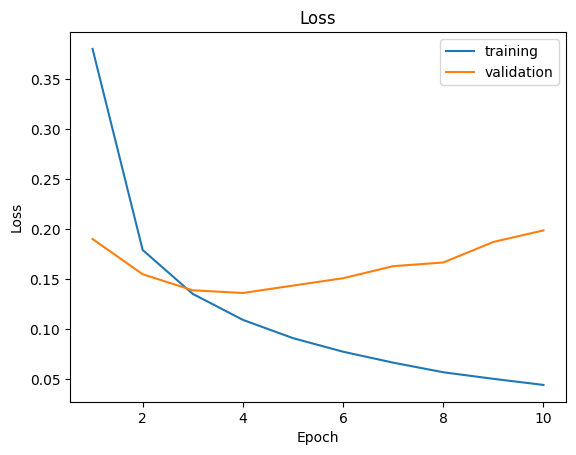

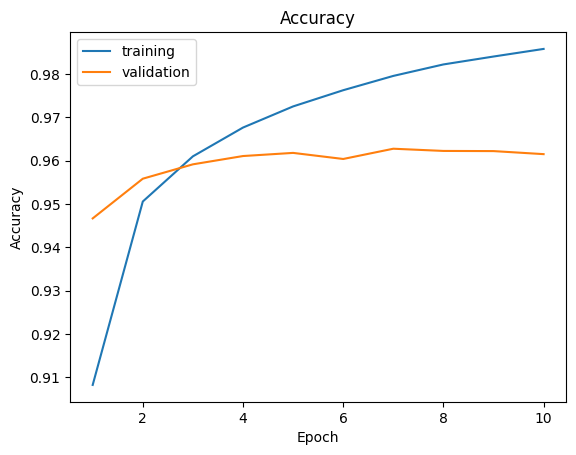

In [25]:
x = np.arange(1, len(train_loss_history)+1, dtype=int)

# Loss 그래프
_, ax = plt.subplots()
ax.plot(x, train_loss_history, label="training")
ax.plot(x, validation_loss_history, label="validation")
ax.set_title('Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

# Accuracy 그래프
_, ax = plt.subplots()
ax.plot(x, train_accuracy_history, label="training")
ax.plot(x, validation_accuracy_history, label="validation")
ax.set_title('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

## 평가

평가에는 test set을 이용한다. 이를 batch size 단위로 불러오기 위해 dataloader를 만든다. 그러나 학습이 아니기 때문에 batch size 단위로 평가할 필요는 없다. 단지, 한 번에 메모리로 불러오는 부담을 줄이기 위해서이다.

**지시: Test accuracy가 95%가 넘도록 모델 및 하이퍼파라미터를 설정한다.**

In [26]:
model.cuda()

testset_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)
test_loss, test_accuracy = test_loop(testset_loader, model, loss_function) # test set을 이용해 평가한다.

print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

Test accuracy: 0.9621311694001562, Test loss: 0.19909070469978696


Test set에 있는 일부 문장 중, 임의로 한 개 선택해서 예측이 잘 되는지 확인해 본다.

우선 테스트셋에서 한 개의 문장을 가져온다.

In [27]:
import random

r = random.randint(0, len(testset)) # 임의의 문장 번호를 선택
X_test, y_test = testset[r] # 임의의 데이터를 가져온다.

# index에서 token을 찾는 사전 생성
# index2token은 학습에는 필요 없으나, 학습 및 추론 결과를 사용자에게 보여주기 위해 필요하다.
# 즉, 인덱스로 표현된 문장을 사용자가 볼 수 있는 문자로 변환할 때 사용한다.
index2token = {v:k for k,v in token2index.items()}

# X_test를 문장으로 변환한다.
tokens = []
for index in X_test.tolist():
    if index == 0: break # <PAD>이면 종료
    tokens.append(index2token[index])

# 토큰을 연결하여 문장을 만든다.
sentence = ' '.join(tokens)
print(sentence)

Meanwhile , the United Nations Security Council renewed for another year its Assistance Mission for Iraq ( UNAMI ) .


In [28]:
X_test.shape

torch.Size([104])

테스트 데이터에 대해 NER 작업을 한다.

In [29]:
model.cpu()
model.eval()

with torch.no_grad():
  # X_test의 shape에는 batch size에 대한 차원이 없으므로, 이를 추가해줘야 한다.
  # 즉, (104)를 (1, 104)로 변환한다.
  X_sample = X_test.unsqueeze(dim=0)
  output = model(X_sample)

output_view = output.view(-1, len(tag2index))
prediction = output_view.argmax(1) # 예측한 결과
prediction = prediction[:len(tokens)].tolist()

index2tag = {v:k for k,v in tag2index.items()} # index에서 tag를 찾는 사전 생성

predicted_tags = [index2tag[index] for index in prediction]
print("예측:", predicted_tags)

y_sample = y_test[:len(tokens)].tolist()
true_tags = [index2tag[index] for index in y_sample]
print("정답:", true_tags)

예측: ['O', 'O', 'O', 'B-org', 'I-org', 'I-org', 'I-org', 'O', 'O', 'B-tim', 'O', 'O', 'B-org', 'I-org', 'I-org', 'B-geo', 'O', 'B-org', 'O', 'O']
정답: ['O', 'O', 'O', 'B-org', 'I-org', 'I-org', 'I-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'B-geo', 'O', 'O']


문장에 태그를 붙여 출력한다.

In [30]:
from IPython.display import Markdown

dressed_sentence = ""

for token, tag in zip(tokens, predicted_tags):
  if tag != 'O':
    token = token + "[" + tag + "]"

  dressed_sentence = dressed_sentence + token + ' '

display(Markdown(dressed_sentence))

Meanwhile , the United[B-org] Nations[I-org] Security[I-org] Council[I-org] renewed for another[B-tim] year its Assistance[B-org] Mission[I-org] for[I-org] Iraq[B-geo] ( UNAMI[B-org] ) . 

이번 과제는 여기까지 입니다. 수고하셨습니다.